In [24]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob         # for reading all calibration images 

# read in the calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# calibrate the camera
objpoints = []  # 3D points in real world
imgpoints = []  # 2D points in image space

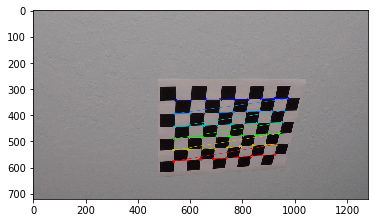

In [25]:
def find_camera_params():
    # since (10,7) image they will have obj points from (0,0,0,) to (9,6,0) 
    # first prepare obj points
    objp = np.zeros((ny*nx,3), np.float32) # Return a new array of given shape and type, filled with zeros
    # Fill the grid with values to (9,6), make a transpose of it and reshape it back to 2 columns, x and y
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for index, fname in enumerate(images):
        # Read in an image
        img = cv2.imread(fname)
        
        # find chessboard corners after converting to greyscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        #if corners found, add to imgpoints and objpoints
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #draw one image with the corners
            if(index==1 ):
                # draw the found corners. img is changed, no return required
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imshow(img)
                #plt.show()

find_camera_params()

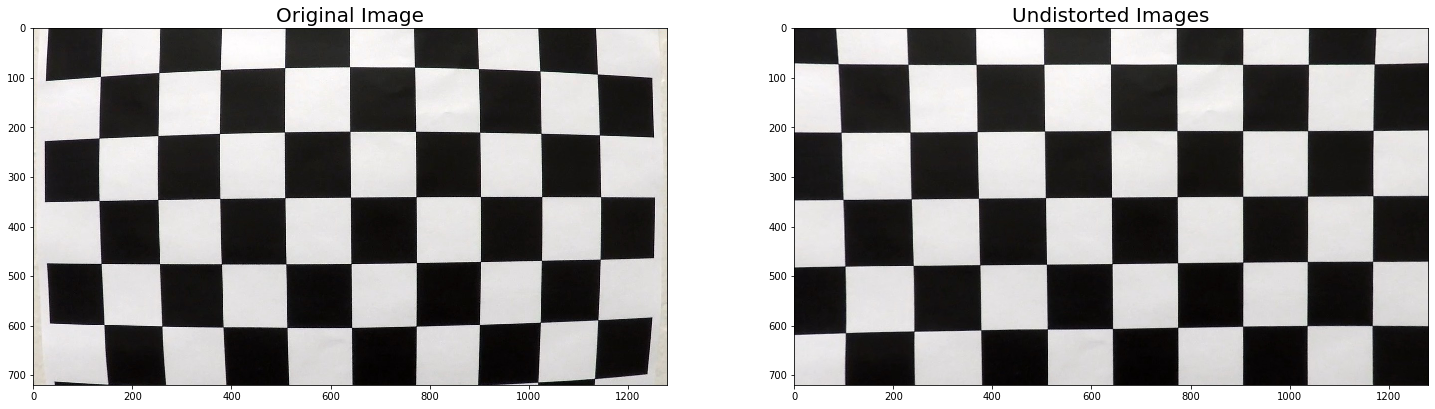

In [26]:
# test the calibration and undistortion on an image
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Print distorted and undistorted images
f,axes = plt.subplots(1,2,figsize=(25,15))
axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=20)
axes[1].imshow(undist)
axes[1].set_title("Undistorted Images", fontsize=20)
plt.show()

720
1280


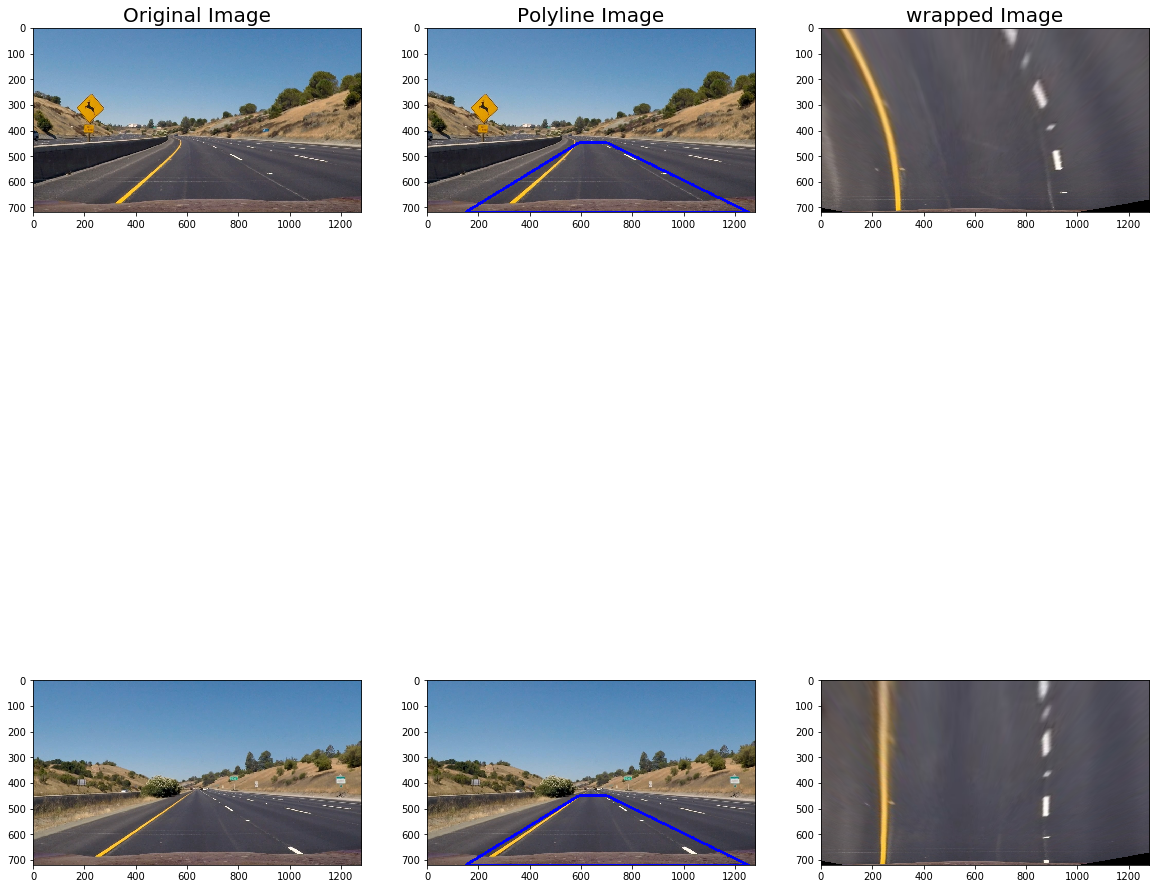

In [27]:
# get the perspective transform   
def corners_unwarp(img,src,dst):
    img_size = (img.shape[1], img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    inv_M = cv2.getPerspectiveTransform(dst,src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M , inv_M

f, axes= plt.subplots(2,3,figsize=(20,20))
f.subplots_adjust(hspace=0.5)

img = mpimg.imread('./test_images/test2.jpg')
print(img.shape[0])
print(img.shape[1])
left_bottom = [150,img.shape[0]]
left_top = [590,450]
right_top = [700,450]
right_bottom = [1250,img.shape[0]]

src = np.float32([left_bottom,left_top, right_top,right_bottom ])
dst = np.float32([[200,img.shape[0]], [200,0], [980,0], [980,img.shape[0]]])
undist = cv2.undistort(img, mtx, dist, None, mtx)

axes[0,0].imshow(img)
axes[0,0].set_title("Original Image", fontsize=20)

# cv2.polylines(img,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)
cv2.polylines(img,np.int32(np.array([[left_bottom,left_top, right_top, right_bottom]])),True,(0,0,255),10)
              
axes[0,1].imshow(img)
axes[0,1].set_title("Polyline Image", fontsize=20)

warped1,persp_M,persp_inv_M   = corners_unwarp(undist,src,dst)

axes[0,2].imshow(warped1)
axes[0,2].set_title("wrapped Image", fontsize=20)


img = mpimg.imread('./test_images/straight_lines1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
axes[1,0].imshow(img)
cv2.polylines(img,np.int32(np.array([[left_bottom,left_top, right_top, right_bottom]])),True,(0,0,255),10)
axes[1,1].imshow(img)
warped1,persp_M,persp_inv_M   = corners_unwarp(undist,src,dst)
axes[1,2].imshow(warped1)

plt.show()

In [28]:
# Apply color transforms and gradients to the images

# get a common function for the channel to extract information
def ExtractChannel(image,colorspace,threshold,channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    extracted_channel = colorspace[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary




In [29]:
def Sobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    arctan= np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobelType=='x'):
        valParam=abs_sobelx
    elif(sobelType=='y'):
        valParam= abs_sobely
    elif(sobelType=='xy'):
        valParam= grad
    else:
        valParam=arctan
        
    
    img = np.uint8((valParam* 255)/np.max(valParam)) # Creating a normalized sobel image
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

Text(0.5, 1.0, 'Combined')

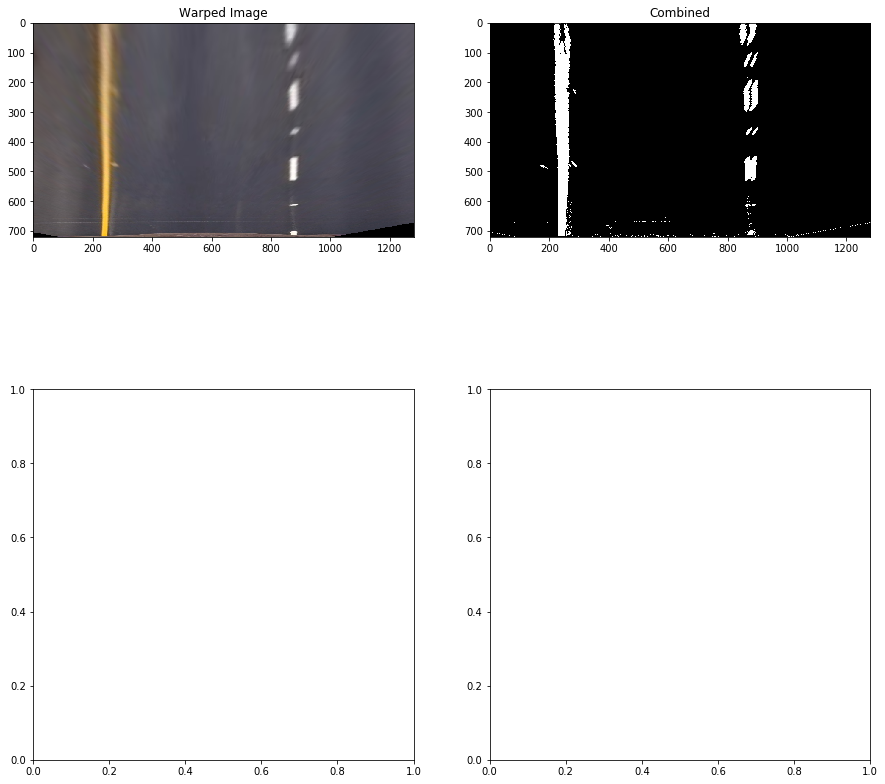

In [30]:
def combineEverything(warpedImage, color_threshold, sobel_threshold):
    
    s_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,2)
    l_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,1)
    y_channel= ExtractChannel(warpedImage,cv2.COLOR_RGB2YUV,color_threshold,0)
    
    sobelx = Sobel(warpedImage, sobel_threshold, 'x')
    sobeldir= Sobel(warpedImage, [0.7,25], 'dir')
    #sobelxy=Sobel(warpedImage, sobel_threshold, 'xy')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

# Testing Color Spaces on Test Images

f, axes= plt.subplots(2,2,figsize=(15,15))
#f.subplots_adjust(hspace=0.5)

index=0
#for index,image in enumerate(warpedImages[0:1]):

"""threshold= [100,255]
index=0
axes[index,0].imshow(image)
axes[index,0].set_title("Original Image")

axes[index+1,0].imshow(image)
axes[index+1,0].set_title("Original Image")

axes[index+2,0].imshow(image)
axes[index+2,0].set_title("Original Image")

axes[index+3,0].imshow(image)
axes[index+3,0].set_title("Original Image")

axes[index+4,0].imshow(image)
axes[index+4,0].set_title("Original Image")"""

combinedImage=combineEverything(warped1,[100,255],[10,150])
axes[index,0].imshow(warped1)
axes[index,0].set_title("Warped Image")
axes[index,1].imshow(combinedImage,cmap='gray')
axes[index,1].set_title("Combined")


Text(0.5, 1.0, 'Histogram')

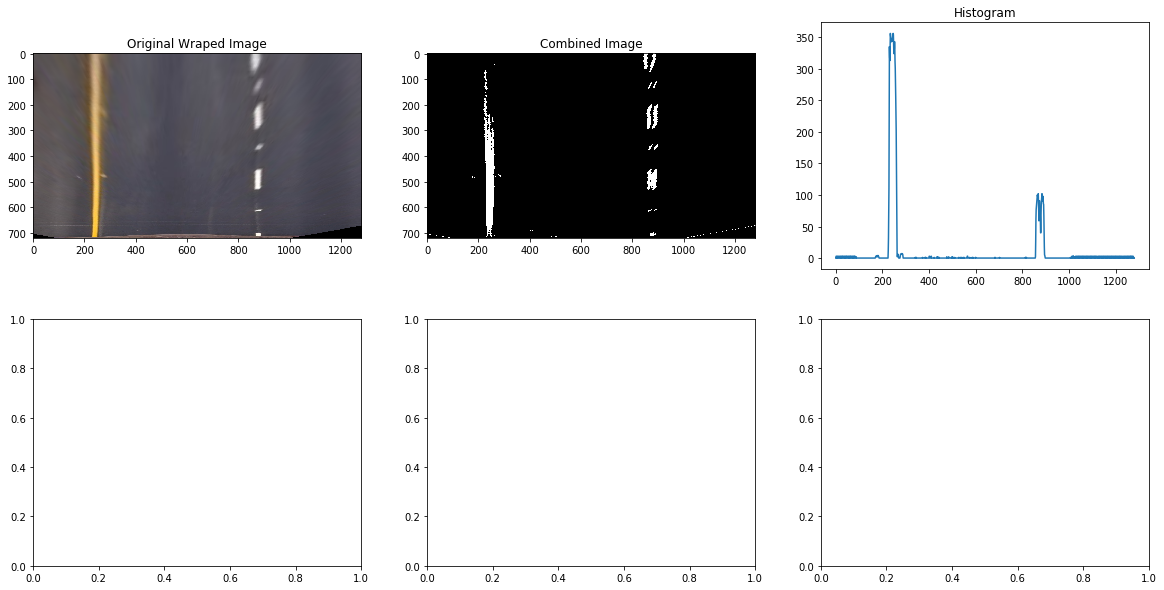

In [31]:
def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    
    
    return histogram

f, axes= plt.subplots(2,3,figsize=(20,10))
axes[index,0].imshow(warped1)
axes[index,0].set_title("Original Wraped Image")
combinedImage=combineEverything(warped1,[150,255],[20,100])
axes[index,1].imshow(combinedImage,cmap="gray")
axes[index,1].set_title("Combined Image")
histogram = hist(combinedImage)
axes[index,2].plot(histogram)
axes[index,2].set_title("Histogram")

In [37]:
# Step 10- Sliding Window Search
def SlidingWindowSearch(binary_warped, plot=False):

    histogram = hist(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

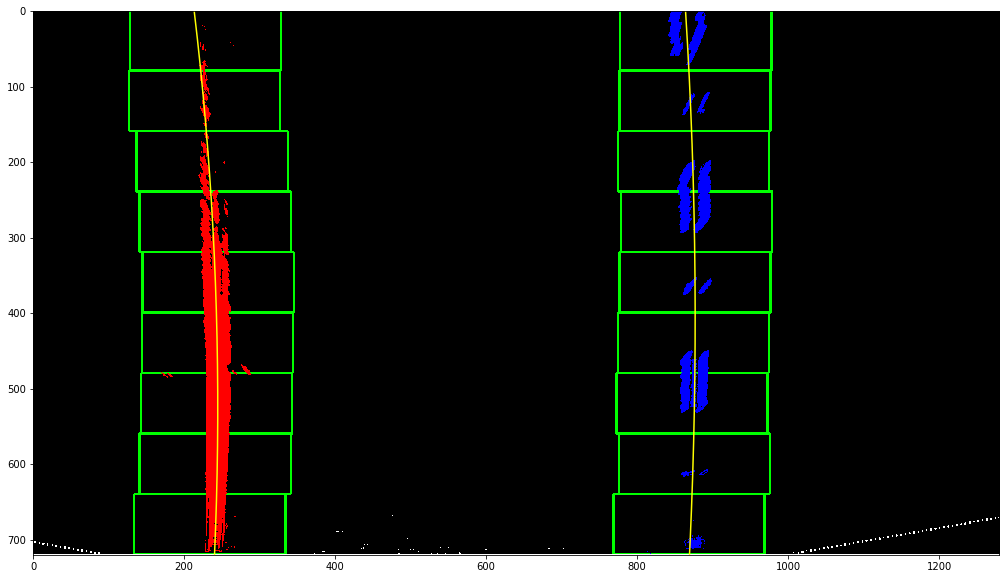

In [38]:
def VisualizeSlidingWindow(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

l,r,ld,rd,o=SlidingWindowSearch(combinedImage, plot=True)
VisualizeSlidingWindow(combinedImage,l,r,ld,rd,o)

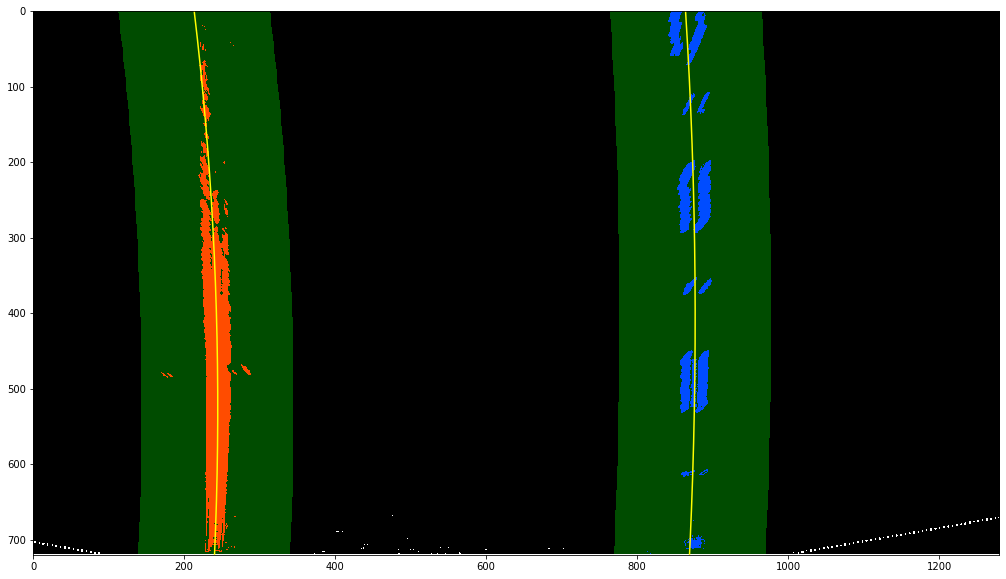

In [39]:
# Visualizing Smoothly

def VisualizeLaneDetection(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l,r,ld,rd,o=SlidingWindowSearch(combinedImage)
VisualizeLaneDetection(combinedImage,l,r,ld,rd,o)

In [40]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit ,leftx, lefty, rightx, righty,out_img

In [41]:
# Unwarp Image and plot line

def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

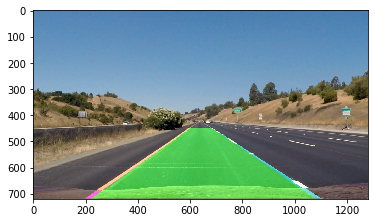

In [44]:
images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder
originalImage= images[0]
originalImage=cv2.cvtColor(cv2.imread(originalImage), cv2.COLOR_BGR2RGB)
returnedOutput =  SlidingWindowSearch(combinedImage)
left_fit=returnedOutput[0]
right_fit=returnedOutput[1]
finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
plt.imshow(finalImage)

In [12]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (np.sqrt(np.power(1 + np.square(2 * left_fit[0] * y_eval + left_fit[1]), 3)))/(2 * left_fit[0])	
    right_curverad = (np.sqrt(np.power(1 + np.square(2 * right_fit[0] * y_eval + right_fit[1]), 3)))/(2 * right_fit[0])
    
    return left_curverad, right_curverad

In [13]:
   
def measure_curvature_real(ploty, left_fit, right_fit,leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 3.0/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/550 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
 
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (np.sqrt(np.power(1 + np.square(2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]), 3)))/np.absolute(2 * left_fit_cr[0])    
    right_curverad = (np.sqrt(np.power(1 + np.square(2 * right_fit_cr[0] * y_eval * ym_per_pix+ right_fit_cr[1]), 3)))/np.absolute(2 * right_fit_cr[0])
    
    print("left_fit_cr , right_fit_cr", left_fit_cr, right_fit_cr)
    
    return left_curverad, right_curverad

In [14]:
comb_binary = color_and_gradient(warped1)
plt.imshow(comb_binary, cmap='gray')

NameError: name 'color_and_gradient' is not defined

In [ ]:
histogram = hist(comb_binary)
plt.plot(histogram)

In [ ]:
ploty, left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_polynomial(comb_binary)
left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit,leftx, lefty, rightx, righty)
#left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)

In [ ]:
result = out_img
# use (arr, cmap='gray') option when you want to show a grey scale image 
#plt.imshow(result, cmap='gray')
plt.imshow(result)
#plt.plot(histogram)
plt.show()
print(left_curverad, right_curverad)